In [393]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure, silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Обработка данных

In [450]:
data = pd.read_csv('./liver_cirrhosis.csv')

In [451]:
print(data.shape)
print(data.head(5))
print(data.info())
print(data.describe())
print(data.isna().sum())

(25000, 19)
   N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   

   Platelets  Prothrombin  Stage  
0      256.0          9.9  

In [452]:
data = data.drop_duplicates()

In [453]:
def plot_categorical_histogram(data, columns_name):
    for i in columns_name:
        plt.figure(figsize=(8, 6))
        sns.countplot(data[i])
        plt.title(f'Гистограмма {i}')
        plt.xlabel(i)
        plt.ylabel('Количество')
        plt.show()

In [454]:
def plot_numerical_boxplot(data, columns_name):
    for i in columns_name:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data[i])
        plt.title(f'Boxplot of {i}')
        plt.xlabel(i)
        plt.show()

Визуализация данных

In [455]:
categorical_list = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numeric_list = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

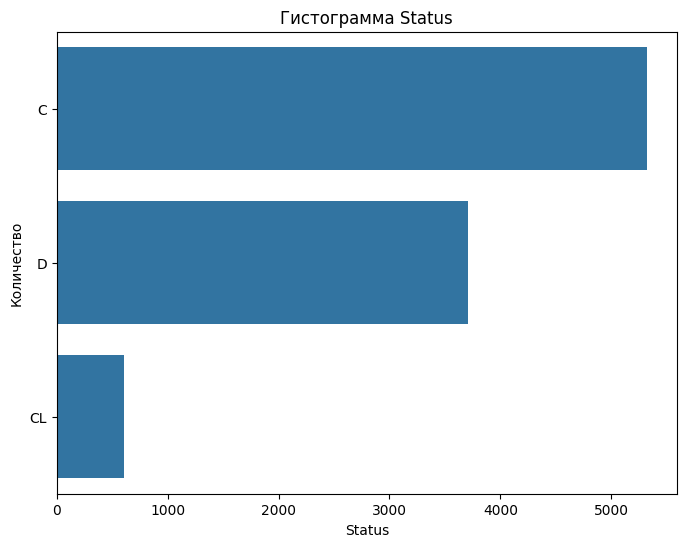

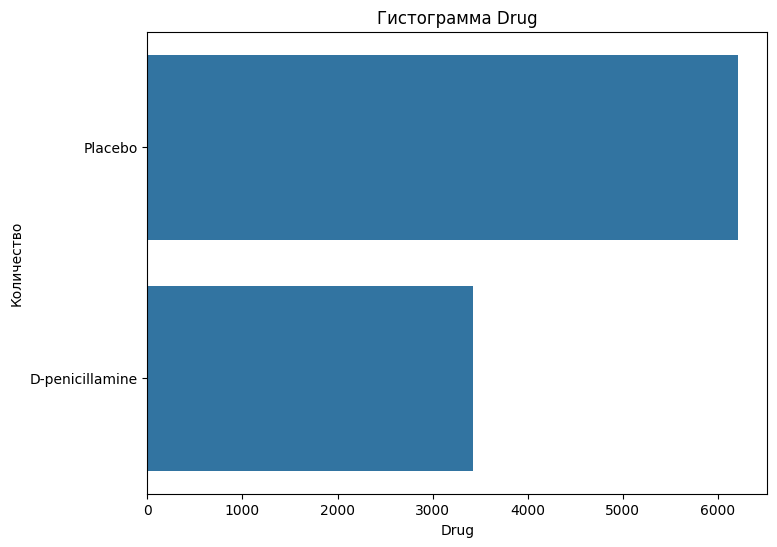

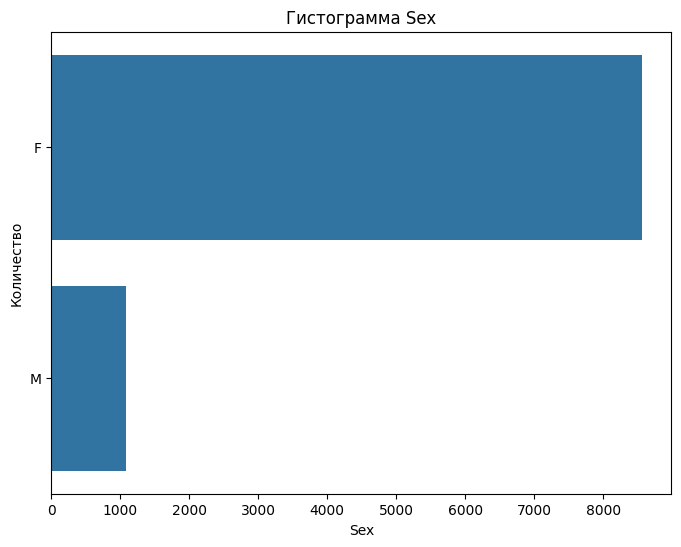

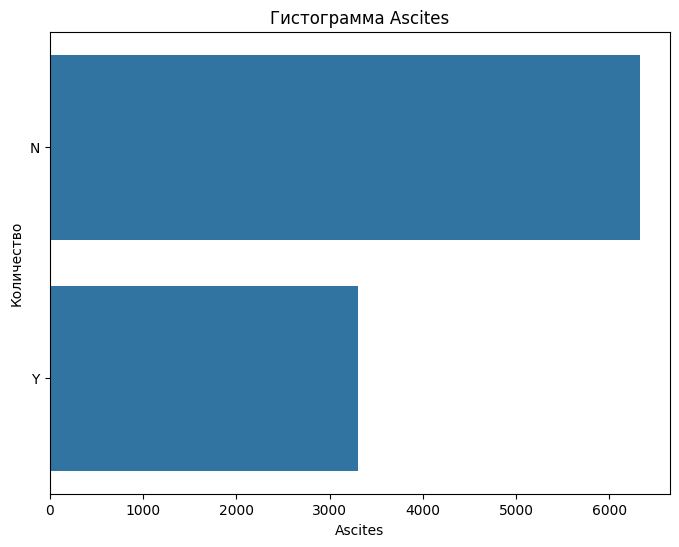

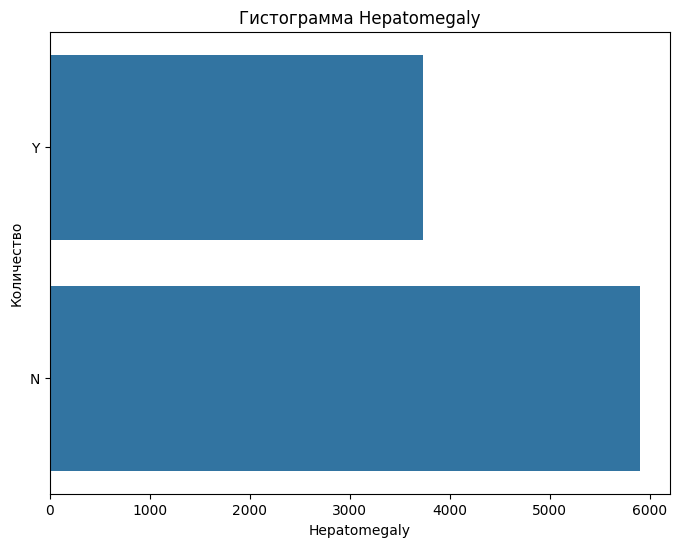

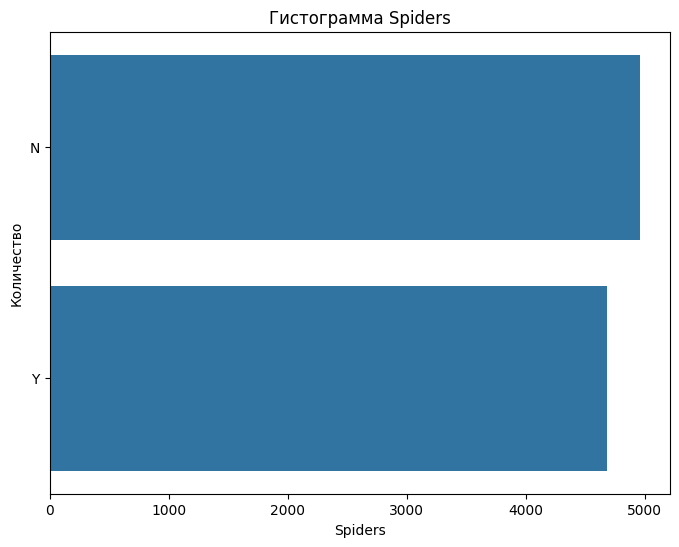

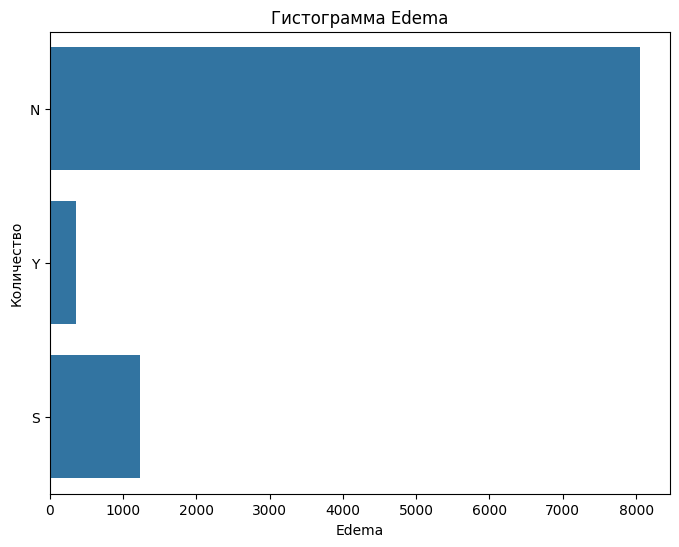

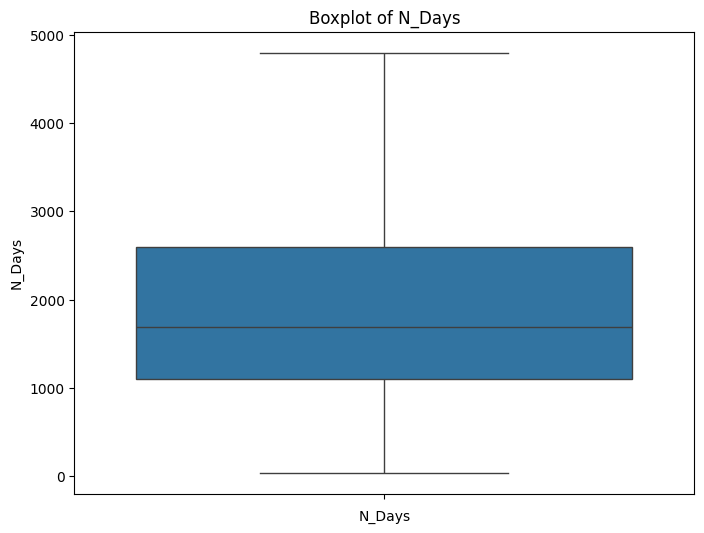

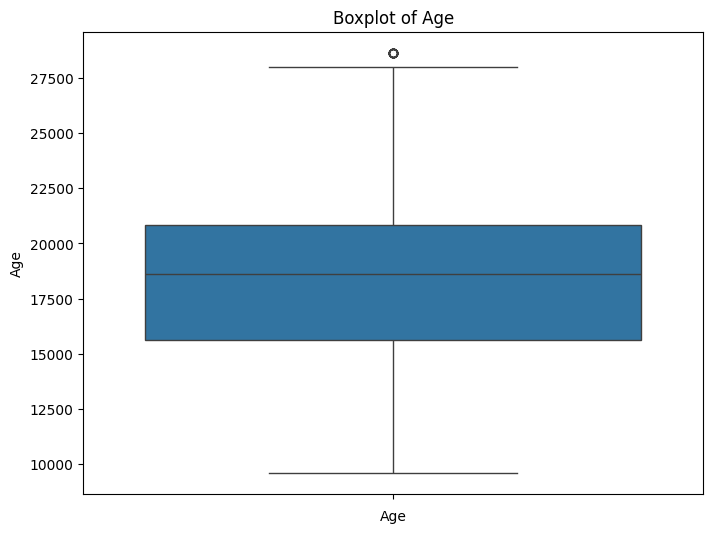

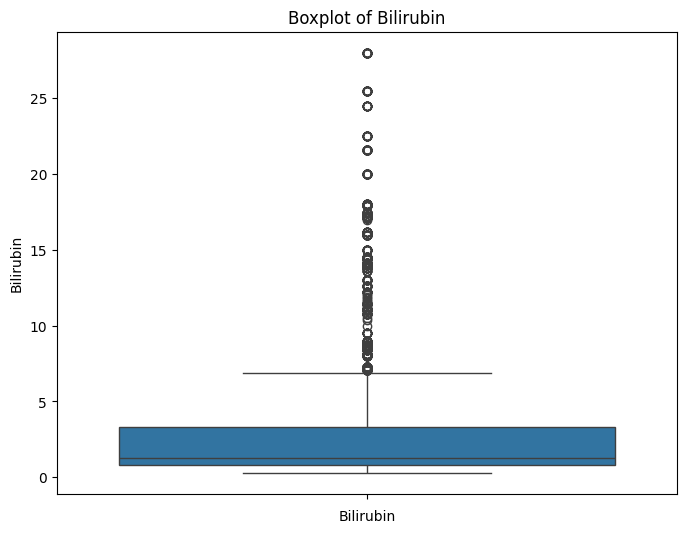

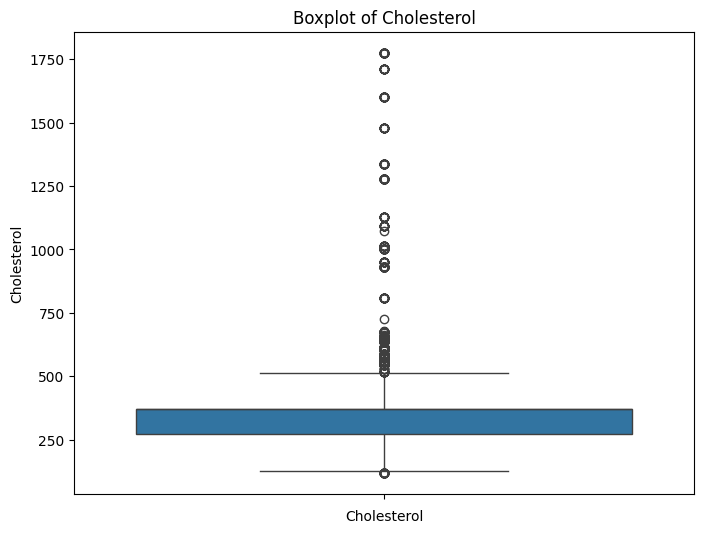

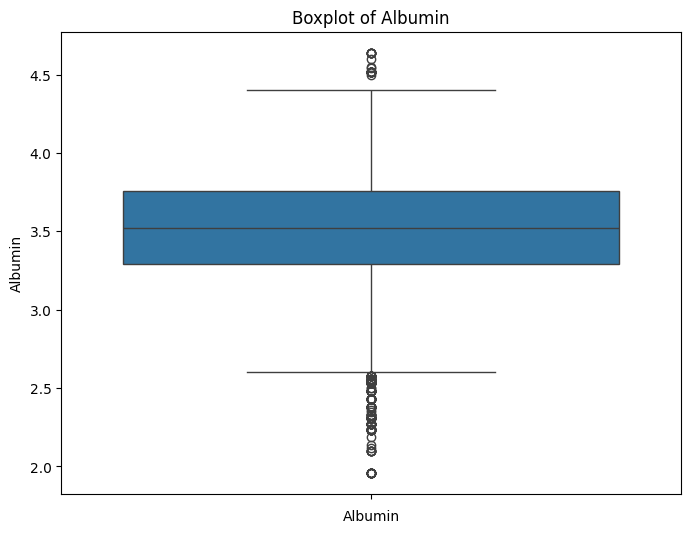

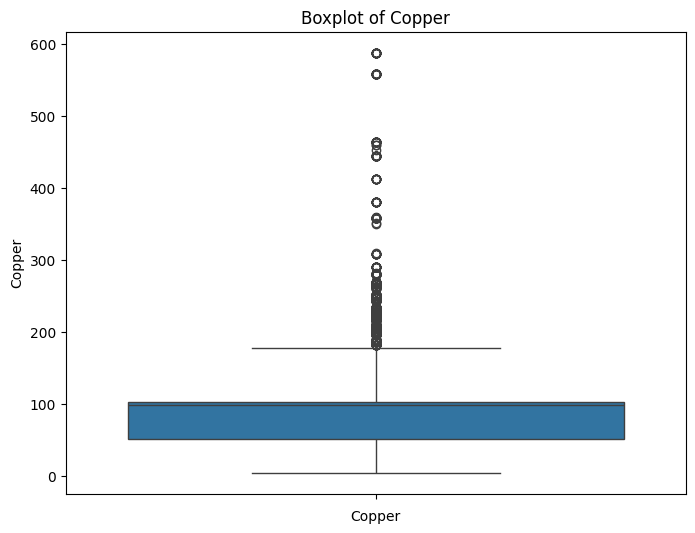

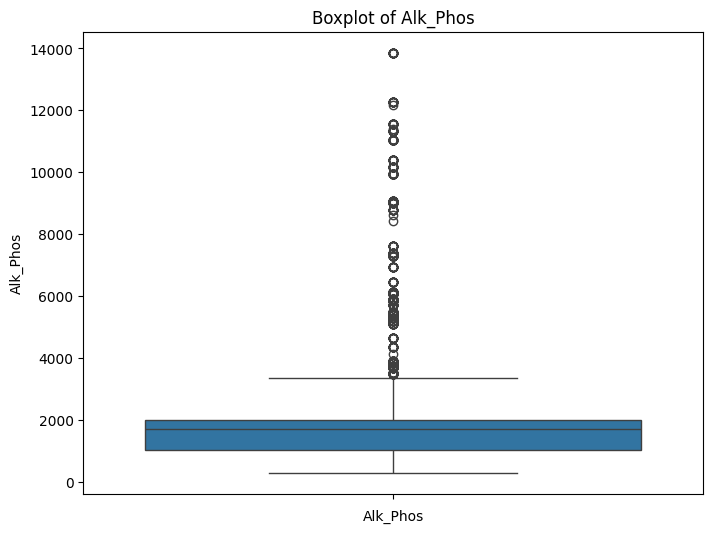

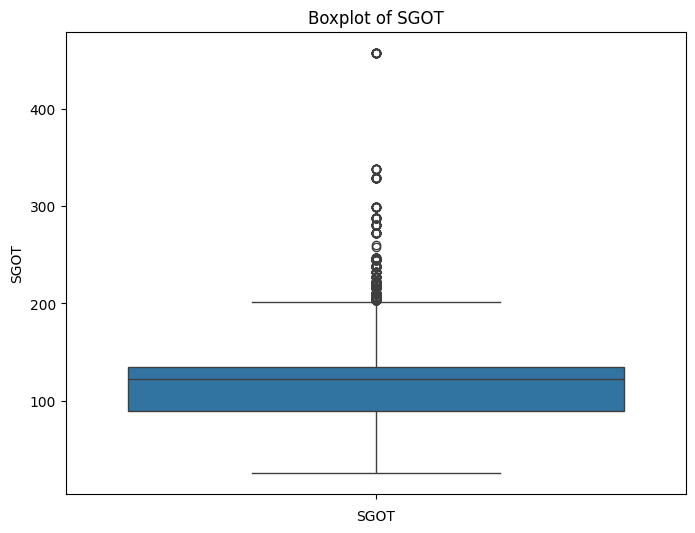

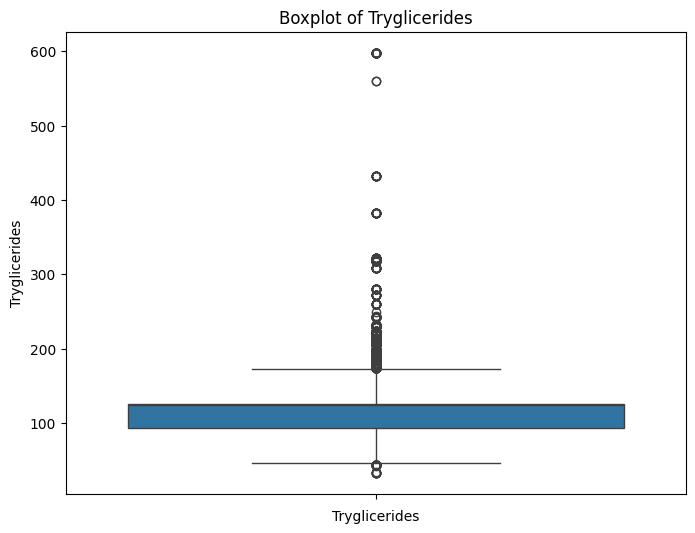

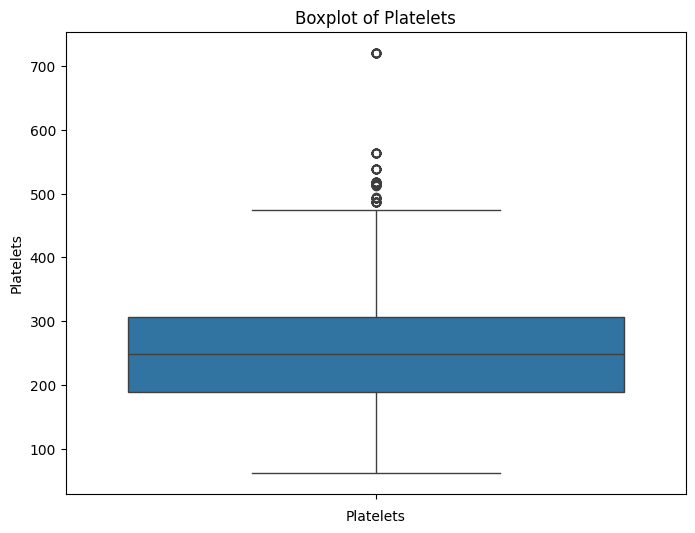

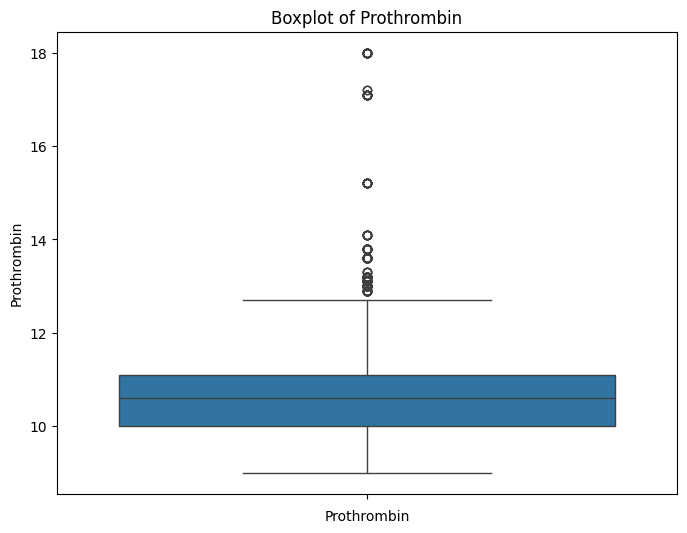

In [456]:
plot_categorical_histogram(data, categorical_list)
plot_numerical_boxplot(data, numeric_list)

Кодирование категориальных переменных

In [457]:
def encode_categorical_variables(df, columns_to_encode):
    encoded_df = df.copy()
    
    for column in columns_to_encode:
        encoded_column = pd.get_dummies(encoded_df[column], prefix=column, drop_first=True, dtype=int)
        encoded_df = pd.concat([encoded_df, encoded_column], axis=1)
        encoded_df.drop(columns=[column], inplace=True)
    
    return encoded_df

In [458]:
data_encoded = encode_categorical_variables(data, categorical_list)
print(data_encoded)

       N_Days    Age  Bilirubin  Cholesterol  Albumin      Copper  \
0        2221  18499        0.5   149.000000     4.04  227.000000   
1        1230  19724        0.5   219.000000     3.93   22.000000   
2        4184  11839        0.5   320.000000     3.54   51.000000   
3        2090  16467        0.7   255.000000     3.74   23.000000   
4        2105  21699        1.9   486.000000     3.54   74.000000   
...       ...    ...        ...          ...      ...         ...   
24963    3577  17897        0.7   369.510563     3.49   97.648387   
24971    4795  23376        1.8   369.510563     3.24   97.648387   
24972    3358  24585        2.1   262.000000     3.48   58.000000   
24991    4365  21324        0.9   346.000000     3.40   81.000000   
24992     694  28650        0.8   300.000000     2.94  231.000000   

          Alk_Phos        SGOT  Tryglicerides  Platelets  ...  Stage  \
0       598.000000   52.700000      57.000000      256.0  ...      1   
1       663.000000   45.000

Построение корреляционной матрицы

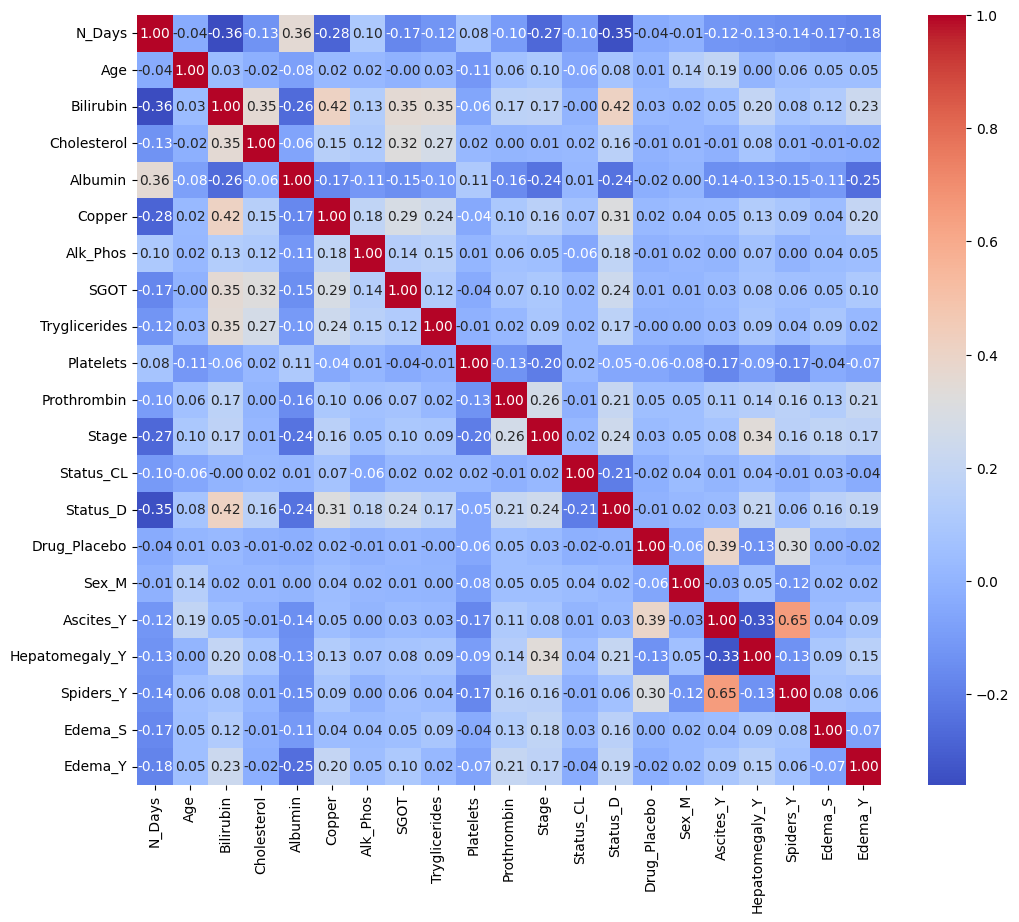

Признаки, которые слабо коррелируют с целевой переменной:
['Cholesterol', 'Status_CL', 'Drug_Placebo', 'Sex_M']

Признаки, которые сильно коррелируют c целевой переменной:
['N_Days', 'Albumin', 'Platelets', 'Prothrombin', 'Stage', 'Status_D', 'Hepatomegaly_Y']


In [459]:
corr_matrix = data_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

target = 'Stage'

weak_correlation_threshold = 0.05
strong_correlation_threshold = 0.2

weak_correlation_features = []
strong_correlation_features = []

for feature in corr_matrix.columns:
    if abs(corr_matrix[target][feature]) < weak_correlation_threshold:
        weak_correlation_features.append(feature)
    elif abs(corr_matrix[target][feature]) > strong_correlation_threshold:
        strong_correlation_features.append(feature)

print("Признаки, которые слабо коррелируют с целевой переменной:")
print(weak_correlation_features)

print("\nПризнаки, которые сильно коррелируют c целевой переменной:")
print(strong_correlation_features)

Удаление выбросов

In [460]:
def remove_outliers(df, columns, threshold):
    df_cleaned = df.copy()  # Создаем копию исходного DataFrame, чтобы не изменять оригинальный

    for column in columns:
        lower_bound = df_cleaned[column].quantile(0.25) - 1.5 * (df_cleaned[column].quantile(0.75) - df_cleaned[column].quantile(0.25))
        upper_bound = df_cleaned[column].quantile(0.75) + 1.5 * (df_cleaned[column].quantile(0.75) - df_cleaned[column].quantile(0.25))
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= threshold) | ((df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound))]
    
    return df_cleaned

In [461]:
# data_encoded = remove_outliers(data_encoded, numeric_list, 12)
# print(data_encoded)

Стандартизация и нормализация

In [462]:
def scale_features(df, numerical_features):
    # Создаем копию исходного DataFrame
    df_scaled = df.copy()
    
    scaler = StandardScaler()
    df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
    
    scaler = MinMaxScaler()
    df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
    
    return df_scaled

In [463]:
cols = data_encoded.columns.tolist()
cols.remove('Stage')
data_scaled = scale_features(data_encoded, cols)
# data_scaled = scale_features(data_encoded, numeric_list)
print(data_scaled)


         N_Days       Age  Bilirubin  Cholesterol   Albumin    Copper  \
0      0.458561  0.467195   0.007220     0.017523  0.776119  0.381849   
1      0.250105  0.531493   0.007220     0.059819  0.735075  0.030822   
2      0.871477  0.117625   0.007220     0.120846  0.589552  0.080479   
3      0.431005  0.360540   0.014440     0.081571  0.664179  0.032534   
4      0.434161  0.635156   0.057762     0.221148  0.589552  0.119863   
...         ...       ...        ...          ...       ...       ...   
24963  0.743795  0.435597   0.014440     0.150762  0.570896  0.160357   
24971  1.000000  0.723179   0.054152     0.150762  0.477612  0.160357   
24972  0.697728  0.786637   0.064982     0.085801  0.567164  0.092466   
24991  0.909550  0.615473   0.021661     0.136556  0.537313  0.131849   
24992  0.137358  1.000000   0.018051     0.108761  0.365672  0.388699   

       Alk_Phos      SGOT  Tryglicerides  Platelets  ...  Stage  Status_CL  \
0      0.022765  0.061151       0.042478   0.

Разделение данных

In [464]:
data_scaled = data_scaled[strong_correlation_features]

true_labels = data_scaled['Stage']
data_n = data_scaled.drop('Stage', axis=1)

In [465]:
print(true_labels)
print(data_n)

0        1
1        2
2        2
3        2
4        1
        ..
24963    1
24971    1
24972    3
24991    2
24992    3
Name: Stage, Length: 9639, dtype: int64
         N_Days   Albumin  Platelets  Prothrombin  Status_D  Hepatomegaly_Y
0      0.458561  0.776119   0.294385     0.100000       0.0             1.0
1      0.250105  0.735075   0.239757     0.200000       0.0             0.0
2      0.871477  0.589552   0.247344     0.111111       0.0             0.0
3      0.431005  0.664179   0.135053     0.133333       1.0             0.0
4      0.434161  0.589552   0.135053     0.277778       1.0             1.0
...         ...       ...        ...          ...       ...             ...
24963  0.743795  0.570896   0.274659     0.077778       0.0             0.0
24971  1.000000  0.477612   0.116844     0.166667       0.0             0.0
24972  0.697728  0.567164   0.531108     0.311111       1.0             1.0
24991  0.909550  0.537313   0.251897     0.144444       0.0             0.0
249

## KMeans

In [466]:
kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42, init='k-means++')

kmeans_clusters = kmeans.fit_predict(data_n)

# Оценка согласованности с истинными метками классов
ari = adjusted_rand_score(true_labels, kmeans_clusters)
ami = adjusted_mutual_info_score(true_labels, kmeans_clusters)
hcv = homogeneity_completeness_v_measure(true_labels, kmeans_clusters)
silhouette = silhouette_score(data_n, kmeans_clusters)

print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)
print("Homogeneity, Completeness, V-Measure:", hcv)
print("Silhouette Score:", silhouette)

Adjusted Rand Index: 0.07242477171646924
Adjusted Mutual Information: 0.06605652093777352
Homogeneity, Completeness, V-Measure: (0.064683732953103, 0.06786743064469482, 0.06623734776640787)
Silhouette Score: 0.5164613658213157


## Метод локтя

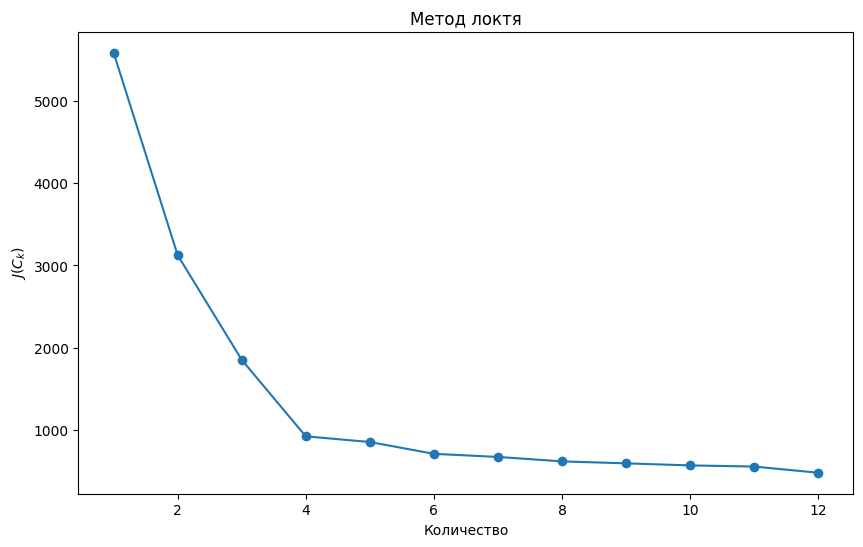

In [467]:
inertia = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_n)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество')
plt.ylabel('$J(C_k)$')
plt.show()

In [468]:
kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++')
kmeans_clusters = kmeans.fit_predict(data_n)
silhouette = silhouette_score(data_n, kmeans_clusters)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.6321058884020034


## Визуализация данных

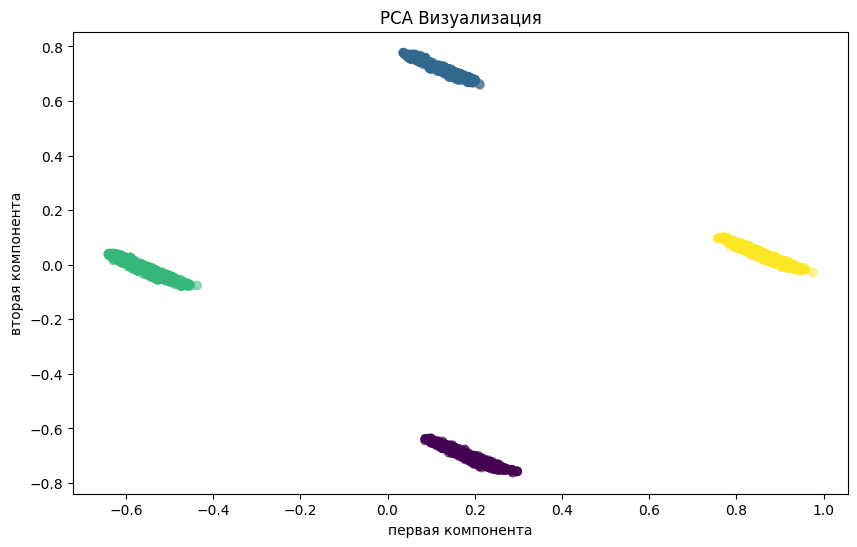

In [469]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_n)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Визуализация')
plt.xlabel('первая компонента')
plt.ylabel('вторая компонента')
plt.show()

## SpectralClustering

In [470]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=len(np.unique(true_labels)), affinity='nearest_neighbors', n_neighbors=15, random_state=42)

spectral_clusters = spectral_clustering.fit_predict(data_n)

ari = adjusted_rand_score(true_labels, spectral_clusters)
ami = adjusted_mutual_info_score(true_labels, spectral_clusters)
hcv = homogeneity_completeness_v_measure(true_labels, spectral_clusters)
silhouette = silhouette_score(data_n, spectral_clusters)

print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)
print("Homogeneity, Completeness, V-Measure:", hcv)
print("Silhouette Score:", silhouette)

D:\Python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Adjusted Rand Index: 0.08590759521999725
Adjusted Mutual Information: 0.07335132458792776
Homogeneity, Completeness, V-Measure: (0.07173126065734209, 0.07542322092783896, 0.07353092697838623)
Silhouette Score: 0.5127818159232321


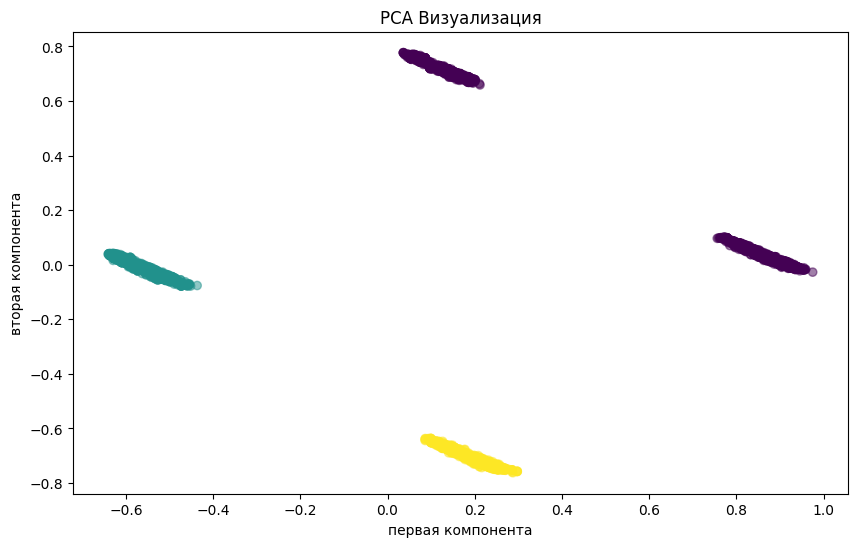

In [471]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_n)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spectral_clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Визуализация')
plt.xlabel('первая компонента')
plt.ylabel('вторая компонента')
plt.show()